# Big Bang Nucleosynthesis

In this code, we will set up and solve nucleosynthesis in the early universe.

In [1]:
# Import Statements
from constants import *
from rates import *
import numpy as np
from scipy.integrate import quad, solve_ivp, cumtrapz, quadrature
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from scipy.interpolate import interp1d
from scipy.optimize import approx_fprime
#import numdifftools as ndt

## Thermodynamics of the Early Universe


From Wagoner, Fowler, and Hoyle's 1967 *Synthesis of Elements*, we have that, from the Friedman equations,

$$\frac{dT}{dt} = \frac{d\rho}{dt} \cdot \frac{dT}{d\rho} = 3H(\rho + pc^2) \cdot \frac{dT}{d\rho} = (24 \pi G \rho)^{1/2} \left(\rho_{\rm rad} + p_{\rm rad}/c^2\right) \left( \frac{d\rho_{\rm rad}}{dT}\right)^{-1}$$

Which they show can be integrated (from $t=0$ and $T = \infty$) to give that

$$T = (12 \pi G \sigma c^{-2})^{1/4}t^{-1/2}$$

Which corresponds to approximately

$$T_9 \simeq 10.4 t^{-1/2}$$
Where $T_9$ is in $10^9 ~\rm {K}$ and $t$ is in seconds. So, rearranging, we can get that

$$\boxed{t = \left(\frac{T_9}{10.4}\right)^{-2}}$$

Furthermore, to find the neutrino temperature, we need to know the radiation energy densities and pressures. We can compute neutrino temperature as a function of photon temperature knowing only the photon and electron energy densities and pressures. More specifically, from Wagoner, we have that the ratio of the photon and neutrino temperatures is

$$\frac{T_\gamma}{T_\nu} = \left(\frac{11}{4} \frac{\rho_\gamma + p_\gamma c^{-2}}{\rho_{\rm rad} + p_{\rm rad} c^{-2}}\right)^{1/3}$$

Thus, we can rearrange this expression to solve for neutrino temperature:

$$\boxed{T_\nu = T_\gamma \left(\frac{11}{4} \frac{\rho_\gamma + p_\gamma c^{-2}}{\rho_{\rm rad} + p_{\rm rad} c^{-2}}\right)^{-1/3}}$$

The expressions for these energy pressures and densities can be given as follows:

$$\rho_\gamma = \frac{\pi^2}{15} T_\gamma^4$$
and
$$p_\gamma = \frac{1}{3} \rho_\gamma c^2$$

In both these, our temperature is in MeV. So, we convert to $T_9$, which gives us that

$$\rho_\gamma \simeq 8.42 T_9^4$$
and $p_\gamma$ is the same. For electrons, it is a bit more complicated:

$$\rho_e = \frac{7}{8} \frac{\pi}{15} T_\gamma^4 (M(Z) - 16M(2Z)) = 15.56 T_9^4 (M(Z) - 16M(2Z)) $$

Where $Z = \frac{m_ec^2}{k_BT_\gamma} = \frac{5.93}{T_9}$ and $M(Z)$ is

$$M(Z) = \bar K_3(Z) + \frac{Z^2}{24} \bar K_1(Z)$$

Where $\bar K_n(Z)$ is

$$\bar K_n(Z) = \frac{2}{(n-1)!} \left(\frac{Z}{2}\right)^n \cdot K_n(Z)$$

Where $K_n$ is the modified Bessel function of the second kind.

Finally, $\rho_{\rm rad} = \rho_\gamma + \rho_e$ and $p_{\rm rad} = p_e + p_\gamma$. We compute below:

In [2]:
def Temperature(Ti, Tf, n):
    
    T9 = np.geomspace(Ti,Tf, n)
    z = 5.93/T9
    
    𝜌𝛾 = 8.42* T9**4
    𝜌e = 15.56 * T9**4 * (M(z) - 1/16 * M(2*z))
    
    𝜌rad = 𝜌𝛾 + 𝜌e
    p𝛾 = 1/3 * 𝜌𝛾
    
    pe = 5.19*T9**4 * (kbar(2,z) - 1/16 * kbar(2,2*z))
    prad = p𝛾 + pe

    T𝜈 = (((11/4) * (𝜌𝛾 + p𝛾))/(𝜌rad + prad))**(-1/3) * T9
    t = (T𝜈/10.4)**(-2)
    
    return np.asarray([T9, T𝜈, t])

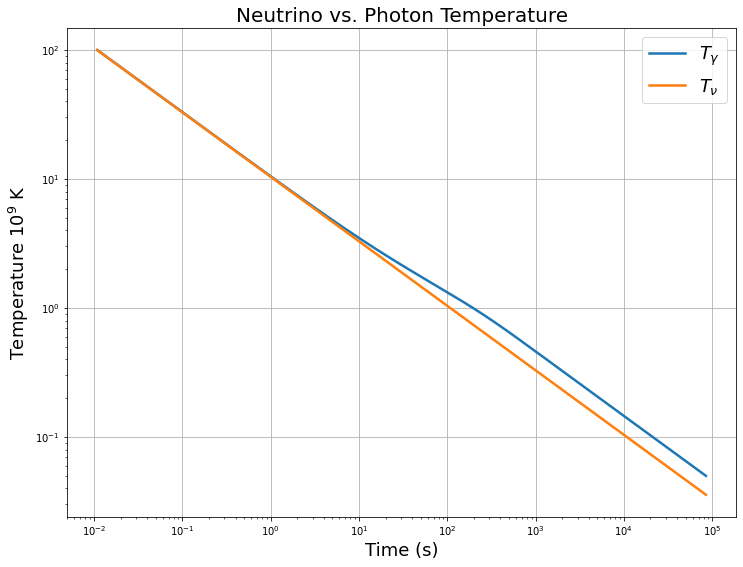

In [3]:
TPhoton, TNeutrino, time = Temperature(100,0.05,500)
figure(figsize=(12,9))
plt.loglog(time, TPhoton, linewidth=2.5);
plt.loglog(time, TNeutrino, linewidth=2.5);
plt.title('Neutrino vs. Photon Temperature', fontsize=20)
plt.ylabel(r'Temperature $10^9 ~\rm{K}$', fontsize=18)
plt.xlabel(r'Time (s)',fontsize=18);
plt.grid()
plt.legend([r'$T_\gamma$', r'$T_\nu$'], fontsize=18);

## Weak Rates

The weak interactions are those between protons and neutrons. Namely, the following reactions:

$$n + \nu_e \leftrightarrows p + e^-$$
$$n + e^+ \leftrightarrows p + \overline{\nu}_e$$
$$n \leftrightarrows p + e^- + \overline{\nu}_e$$

We denote the rate $\lambda_{n \rightarrow p}$ as the sum of all of the forward weak reactions and likewise $\lambda_{p \rightarrow n}$ as the sum of all the reverse weak reactions. From Kawano 1992, we have that 


$$\lambda_{p \rightarrow n} = \frac{1}{\tau} \int_1^\infty dx \frac{x(x+q)^2 (x^2 - 1)^{1/2}}{\left(1+e^{-xz}\right)[1 + e^{(x+q)z_{\nu} + \xi_e}]} + \frac{1}{\tau} \int_1^\infty dx \frac{x(x-q)^2 (x^2 - 1)^{1/2}}{\left(1+e^{xz}\right)[1 + e^{-(x-q)z_{\nu} + \xi_e}]}$$

and that

$$\lambda_{n \rightarrow p} = \lambda_{n\rightarrow p}(-q,-\xi_e)$$
Where we have that the variables:

- $q = (m_n - m_p)/m_e$ is the neutron-proton mass difference divided by the electron mass
- $z = m_ec^2/k_B T_\gamma$ is a substitution
- $z_\nu = m_ec^2/k_B T_\nu$ is the same as $z$ but for the neutrino temperature
- $\tau$ is the lifetime of a neutron.
- $\xi_e$ is the chemical potential of the electron, taken to be zero but included as a manual override such that non-zero $\xi_e$ can be evaluated if desired.

This is a somewhat cumbersome integral, but can be evaluated quickly using SciPy's `integrate.quad`, which we do below.

In [4]:
def WeakRateAnalytic(Tγ, T𝜈, ξe=0):
    
    '''
    Function for computing the weak rates for protons and neutrons.
    
    INPUT:
    T : Temperature matrix of photons and neutrinos in MeV/kB [2 x n ndarray]
    
    OUTPUT: 
    lambda_np : Weak rate matrix where the first column is n->p and the second is p->n [2 x n ndarray]
    '''
    
    K = 1/τ

    def integrand(x, Tγ, T𝜈, q=q):
        
        '''
        Internal method returning the integrand of the weak rates.
        '''
        z = (me/(Tγ*kB))
        z𝜈 = (me/(T𝜈*kB))
        IntegrandArray = K * ((x * (x+q)**2 * (x**2 -1)**(1/2))/((1+np.exp(-x*z)) * (1+np.exp((x+q)*z𝜈 + ξe))) +\
             (x * (x-q)**2 * (x**2 -1)**(1/2))/((1+np.exp(x*z)) * (1+np.exp(-(x-q)*z𝜈 + ξe))))
    
        return IntegrandArray


    def integration(Tγ, T𝜈, q=q, ξe=ξe):
        '''
        Internal method integrating the integrand from 1 to infinity with resepct to x.
        '''
        
        WeakRate = quadrature(integrand, 1, np.inf, args=(Tγ,T𝜈,q))[0]
        
        return WeakRate

    # Vectorization
    vec_integration = np.vectorize(integration)
    
    lambda_np = vec_integration(Tγ, T𝜈)
    lambda_pn = vec_integration(Tγ, T𝜈, q=-q, ξe=-ξe)

    return lambda_np, lambda_pn

def weak_test(Tγ):
    
    #Z = (me/(Tγ*kB))
    Z = 5.93/Tγ
    lambda_n = (𝜏**(-1))*(27.512*(Z)**(-5)+36.492*(Z)**(-4)+11.108*(Z)**(-3)-6.382*(Z)**(-2)+0.565*(Z)**(-1)+1)
    lambda_p = (𝜏**(-1))*(27.617*(Z)**(-5)+34.181*(Z)**(-4)+18.059*(Z)**(-3)-16.229*(Z)**(-2)+5.252*(Z)**(-1))*np.exp(-q*Z)
    
    return lambda_n, lambda_p


#p_an, n_an = WeakRateAnalytic(0.8617 * TPhoton/(kB * 1e1), 0.8617 * TNeutrino/(kB * 1e1))
#p_an, n_an = WeakRateAnalytic(1e9 * TPhoton, 1e9 * TNeutrino)


#n_app, p_app = WeakRateAnalytic(TPhoton)

#plt.loglog(TPhoton, p_an)
#plt.loglog(TPhoton, n_an)

#plt.loglog(TPhoton, p_app)
#plt.loglog(TPhoton, n_app)
#plt.legend(['p analytic', 'n analytic', 'p approx', 'n approx'])

## Strong Rates and Differential Equation Structure

The strong reaction rates are composed using the reaction cross-section of each reaction, along with other constants. Furthermore, we have that in a generic four-body reaction, say

$$Y_i + Y_j \underset{[kl]_{ij}}{\overset{[ij]_{kl}}{\rightleftharpoons}} Y_k + Y_l$$

Where we have two species, $Y_i$ and $Y_j$ combining with a rate $[ij]_{kl}$ to produce the two species $Y_k$ and $Y_l$. The reverse rate, $[kl]_{ij}$ is the rate at which $Y_k$ and $Y_l$ combine and produce $Y_i$ and $Y_j$. We are interested in the forward and reverse rates for our reaction network. They can be computed and generally take the form

$$[ij]_{kl} = \rho_b N_A \langle\sigma v\rangle_{jk}$$

Where $\rho_b$ is the baryon density, $N_A$ is Avogadro's number, and 

$$\langle \sigma v \rangle_{jk} = \int_0^\infty f(v, T) \sigma (v) v \, dv$$

is the Boltzmann distribution over the two species and their reaction cross-section $\sigma(v)$.


While this *can* be computed, these rates have already been computed by Fowler, Caughlan, and Zimmerman in their 1975 paper *Thermonuclear Reaction Rates II* or FCZII and in Wagoner 1967. We will use this instead. These rates are located in the file `rates.py`. 

We will consider reactions involving/creating protons, neutrons, Deuterium, Tritium, Helium-3, Helium-4, Lithium-6, Lithium-7, Beryllium-6, and Beryllium-7. While other elements are involved in BBN, these represent the vast majority of reactants by mass fraction. We will consider the following reactions:

$$
p + n \leftrightarrows {\rm{D}} + \gamma\\

p + {\rm{D}} \leftrightarrows {\rm^3He} + \gamma\\

n + {\rm{D}} \leftrightarrows {\rm{T}} + \gamma\\

n + {\rm{^3He}} \leftrightarrows p + {\rm{T}} \\

p + {\rm T} \leftrightarrows {\rm{^4He}} + \gamma \\

n + {\rm ^3He} \leftrightarrows {\rm{^4He}} + \gamma \\

{\rm D} + {\rm D} \leftrightarrows n + {\rm{^3He}} \\

{\rm D} + {\rm D} \leftrightarrows p + {\rm{T}} \\

{\rm D} + {\rm D} \leftrightarrows {\rm{^4He}} + \gamma \\

{\rm D} + {\rm  ^3He} \leftrightarrows {\rm{^4He}} + p \\

{\rm D} + {\rm  T} \leftrightarrows {\rm{^4He}} + n \\

{\rm ^3He} + {\rm  ^3He} \leftrightarrows {\rm{^4He}} + p + p \\

{\rm T} + {\rm  T} \leftrightarrows {\rm{^4He}} + n + n \\

{\rm ^3He} + {\rm  T} \leftrightarrows {\rm{^4He}} + p + n \\

{\rm ^3He} + {\rm  T} \leftrightarrows {\rm{^4He}} + {\rm D} \\

{\rm ^3He} + {\rm  ^4He} \leftrightarrows {\rm{^7Be}} + \gamma \\

{\rm T} + {\rm ^4He} \leftrightarrows {\rm{^7Li}} + \gamma \\

n + {\rm  ^7Be} \leftrightarrows p + {\rm{^7Li}} \\

p + {\rm  ^7Li} \leftrightarrows \rm{^4He} + {\rm{^4He}} \\
$$

The reaction network can be constructed as follows

$$\frac{dY_i}{dt} = \sum_{j,k,l}  N_i \left(\frac{Y_k^{N_k}Y_l^{N_l}}{N_k!N_l!} [kl]_{ij} - \frac{Y_i^{N_i}Y_j^{N_j}}{N_i!N_j!} [ij]_{kl}\right)$$

Which allows us to create a coupled system of first-order non-linear ODEs. Thus, we can integrate with respect to time to obtain $Y_i$ for each species $i$ and determine its relative mass fraction. We set up the differential eqaution below and solve by the Radau method.

## Nuclear Statistical Equilibrium and the Saha Equation

In equilibrium (for a photon temperature of >0.8 MeV or so), the number density of nuclear species is governed by the Saha equation. We can express the mass fraction of elements immediately before BBN begins by knowing only the binding energy and spin states of each nucleus along with the equilibrium mass fractions of protons and neutrons. This is because at high temperatures, *all* species are in equilibrium with protons and neutrons. In NSE, we can express the number density of nuclei of species $X$ as:

$$\frac{n_X}{n_n n_p} = \frac{m_{s,X}}{4} \left(\frac{2\pi m_X}{m_nm_p T}\right)^{3/2} e^{(m_n + m_p - m_X)/T}$$

Where 

- $n_n$, $n_p$, $n_X$ are the number densities of neutrons, protons, and species $X$ respectively
- $m_{s,X}$ is the number of possible spin states of nucleus $X$
- $m_n$, $m_p$, $m_X$ are the masses of neutrons, protons, and species $X$ and
- T is temperature in MeV

This can be reexpressed as a more useful quantity for our case by expressing the number density of a species with respect to the number density of baryons overall. That rexpression, given in Dodelson and Schmidt's *Modern Cosmology* (equation 4.16), is

$$\frac{n_X}{n_b} \sim \eta_b \left(\frac{T}{m_n}\right)^{3/2} e^{B_X/T}$$

Where $\eta_b$ is the baryon to photon ratio and $B_X$ is the binding energy of a nucleus of species $X$. This relation holds when $\eta_b$ dominates the exponential term, and thus holds well for immediately pre-BBN temperatures, since they are not too high.

From Kolb and Turner, we have that the NSE mass fraction of a species X can be expressed as (the somewhat unwieldy) expression:


$$X_A = g_A \left(\zeta (3)^{A-1} \pi^{(1-A)/2} 2^{(3A-5)/2}\right) A^{5/2} \left(\frac{T}{m_p}\right)^{3(A-1)/2} \eta^{A-1} X_p^Z X_n^{A-Z} \exp(B_A/T)$$

In [5]:
def NSEAbundances(T,Bind, A, gA):
    '''
    T - Temperature in MeV
    Bind - Binding energy in MeV
    A - Mass number of the atom
    gA - 
    '''


    coeff = gA * η0**(A-1) * (apery**(A-1) * pow(np.pi, ((1-A)/2)) * pow(2, ((3*A-5)/2))) * A**(5/2)
    #XA = coeff * (T/(A*mn))**((3*(A-1))/2) * np.exp(Bind/T)
    XA = coeff * (T/mn)**((3*(A-1))/2) * np.exp(Bind/T)

    return XA
    
    #nXnb = η0 * (T/mp)**(3/2) * np.exp(Bind/T)
    #return nXnb
    #return 1/(1+(nXnb)**(-1))


In [6]:
def BBNEquation(t, Y):

    Yp, Yn, YD, YT, YHe3, YHe4, YBe7, YLi7, YB8, YB10 = Y

    #YD = (1/2)*YD
    #YT = (1/3)*YT
    #YHe3 = (1/3)*YHe3
    #YHe4 = (1/4)*YHe4
    #YBe7 = (1/7)*YBe7
    #YLi7=(1/7)*YLi7
    #YB8 = (1/8)*YB8
    #YB10 = (1/10)*YB10
    
    T9 = 10.4*(t)**(-1/2)

    z = 5.93/T9
    Tγ = T9
    
    𝜌𝛾 = 8.42* T9**4
    𝜌e = 15.56 * T9**4 * (M(z) - 1/16 * M(2*z))
    𝜌rad = 𝜌𝛾 + 𝜌e
    p𝛾 = 1/3 * 𝜌𝛾
    pe = 5.19*T9**4 * (kbar(2,z) - 1/16 * kbar(2,2*z))
    prad = p𝛾 + pe

    T𝜈 = (((11/4) * (𝜌𝛾 + p𝛾))/(𝜌rad + prad))**(-1/3) * T9

    # Initialize the Weak Rates

    lambda_n, lambda_p = weak_test(Tγ)
    #lambda_p, lambda_p = WeakRateAnalytic(Tγ,Tν)

    ForwardRates, ReverseRates, rhob = StrongRates(Tγ)
    F = ForwardRates
    R = ReverseRates


    # This is a mess, need to procedurally generate matrix lol


    # Forward Equations

    dYpF = -lambda_p*Yp + lambda_n*Yn - F[0]*Yp*Yn - F[1]*Yp*YD + F[3]*Yn*YHe3 - F[4]*Yp*YT + (1/2)*F[7]*YD**2 + F[9]*YD*YHe3  + F[17]*Yn*YBe7 - F[18]*Yp*YLi7 + (1/2)*F[11]*YHe3**2 + F[13]*YHe3*YT - F[20]*Yp*YBe7 -F[21]*Yp*YB10
    dYnF = -lambda_n*Yn + lambda_p*Yp - F[0]*Yp*Yn - F[2]*Yn*YD - F[3]*Yn*YHe3 - F[5]*Yn*YHe3 + (1/2)*F[6]*YD**2 + F[10]*YD*YT + F[14]*YHe3*YT - F[17]*Yn*YBe7 - F[19]*Yn*YBe7 + (1/2)*F[12]*YT**2 - F[22]*Yn*YB10
    dYDF = F[0]*Yp*Yn - F[1]*Yp*YD - F[2]*Yn*YD - F[6]*YD**2 - F[7]*YD**2 - F[8]*YD**2 - F[9]*YD*YHe3 - F[10]*YD*YT  + F[13]*YHe3*YT
    dYTF = F[2]*Yn*YD + F[3]*Yn*YHe3 - F[4]*Yp*YT + (1/2)*F[7]*YD**2 - F[10]*YD*YT - F[14]*YHe3*YT - F[16]*YT*YHe4 - F[12]*YT**2 - F[13]*YHe3*YT
    dYHe3F = F[1]*Yp*YD - F[3]*Yn*YHe3 - F[5]*Yn*YHe3 + (1/2)*F[6]*YD**2 - F[9]*YD*YHe3  - F[14]*YHe3*YT- F[15]*YHe3*YHe4 - F[11]*YHe3**2 - F[13]*YHe3*YT
    dYHe4F = F[4]*Yp*YT + F[5]*Yn*YHe3 + (1/2)*F[8]*YD**2 + F[9]*YD*YHe3 + F[10]*YD*YT + (1/2)*F[11]*YHe3**2  + F[14]*YHe3*YT - F[15]*YHe3*YHe4 - F[16]*YT*YHe4 + F[18]*Yp*YLi7 + F[19]*Yn*YBe7 + (1/2)*F[12]*YT**2 + F[13]*YHe3*YT + F[21]*Yp*YB10 + F[22]*Yn*YB10
    dYBe7F = F[15]*YHe3*YHe4 - F[17]*Yn*YBe7 - F[19]*Yn*YBe7 - F[20]*Yp*YBe7 + F[21]*Yp*YB10
    dYLi7F = F[16]*YT*YHe4 + F[17]*Yn*YBe7 - F[18]*Yp*YLi7 + F[22]*Yn*YB10
    dYB8F = F[20]*Yp*YBe7
    dYB10F = -F[21]*Yp*YB10 - F[22]*Yn*YB10
    # Reverse Equations

    dYpR = R[0]*YD + R[1]*YHe3 - R[3]*Yp*YT + R[4]*YHe4 - R[7]*Yp*YT - R[9]*Yp*YHe4 - R[17]*YLi7*Yp + (1/2)*R[18]*YHe4**2 - R[11]*Yp**2*YHe4 - R[13]*Yp*Yn*YHe4 + R[20]*YB8 + R[21]*YHe4*YBe7
    dYnR = R[0]*YD + R[2]*YT + R[3]*Yp*YT + R[5]*YHe4 - R[6]*Yn*YHe3 - R[10]*Yn*YHe4 + R[17]*YLi7*Yp + (1/2) *R[19]*YHe4**2 - R[12]*Yn**2*YHe4 - R[13]*Yp*Yn*YHe4 + R[22]*YHe4*YLi7
    dYDR = - R[0]*YD + R[1]*YHe3 + R[2]*YT + 2*R[6]*Yn*YHe3 + 2*R[7]*Yp*YT + 2* R[8]*YHe4 + R[9]*Yp*YHe4 + R[10]*Yn*YHe4 - R[14]*YD*YHe4
    dYTR = - R[2]*YT - R[3]*Yp*YT + R[4]*YHe4 - R[7]*Yp*YT + R[10]*Yn*YHe4 + R[14]*YD*YHe4 + R[16]*YLi7 + (1/2)*R[12]*Yn**2*YHe4 + R[13]*Yp*Yn*YHe4
    dYHe3R = - R[1]*YHe3 + R[3]*Yp*YT + R[5]*YHe4 - R[6]*Yn*YHe3 + R[9]*Yp*YHe4  + R[14]*YD*YHe4 + R[15]*YBe7 + (1/2)*R[11]*Yp**2*YHe4 + R[13]*Yp*Yn*YHe4
    dYHe4R = - R[4]*YHe4 - R[5]*YHe4 - R[8]*YHe4 - R[9]*Yp*YHe4 - R[10]*Yn*YHe4 -R[14]*YD*YHe4 + R[15]*YBe7 + R[16]*YLi7 - R[18]*YHe4**2 - R[19]*YHe4**2 - (1/2)*R[11]*Yp**2*YHe4 - (1/2)*R[12]*Yn**2*YHe4 - R[13]*Yp*Yn*YHe4 - R[21]*YHe4*YBe7 - R[22]*YHe4*YLi7
    dYBe7R = - R[15]*YBe7 + R[17]*YLi7*Yp + (1/2) * R[19]*YHe4**2 + R[20]*YB8 - R[21]*YHe4*YBe7
    dYLi7R = - R[16]*YLi7 - R[17]*YLi7*Yp + (1/2)*R[18]*YHe4**2 - R[22]*YHe4*YLi7
    dYB8R = -R[20]*YB8
    dYB10R = R[21]*YHe4*YBe7 + R[22]*YHe4*YLi7
    # Sum total derivatives and return

    dYp = dYpF + dYpR
    dYn = dYnF + dYnR
    dYD = dYDF + dYDR
    dYT = dYTF + dYTR
    dYHe3 = dYHe3F + dYHe3R
    dYHe4 = dYHe4F + dYHe4R
    dYBe7 = dYBe7F + dYBe7R
    dYLi7 = dYLi7F + dYLi7R
    dYB8 = dYB8F + dYB8R
    dYB10 = dYB10F + dYB10R

    return np.asarray([dYp, dYn, dYD, dYT, dYHe3, dYHe4, dYBe7, dYLi7, dYB8, dYB10])

In [7]:
def BBNEquation1(t,Y):
    
    Yp, Yn, YD, YT, YHe3, YHe4, YBe7, YLi7 = Y
    
    T9 = 10.4*(t)**(-1/2)

    z = 5.93/T9
    Tγ = T9
    
    𝜌𝛾 = 8.42* T9**4
    𝜌e = 15.56 * T9**4 * (M(z) - 1/16 * M(2*z))
    𝜌rad = 𝜌𝛾 + 𝜌e
    p𝛾 = 1/3 * 𝜌𝛾
    pe = 5.19*T9**4 * (kbar(2,z) - 1/16 * kbar(2,2*z))
    prad = p𝛾 + pe

    T𝜈 = (((11/4) * (𝜌𝛾 + p𝛾))/(𝜌rad + prad))**(-1/3) * T9

    # Initialize the Weak Rates

    lambda_n, lambda_p = weak_test(Tγ)
    ForwardRates, ReverseRates = StrongRates(Tγ)

    ForwardRates = np.append([lambda_n, lambda_p], ForwardRates)

    #[ . . . ] [ . ] --> Einsum ij, ij->j does:
    #[ . A . ] [ Y ] --> AY matrix multiplication, sum across rows of AY.
    #[ . . . ] [ . ]

    

    dYForwards = np.einsum('ij,ij->j', ForwardRates, Y)
    dYReverse = np.einsum('ij,ij->j', ReverseRates, -Y)


In [8]:
Ti = 15
Tf = 0.116
Tγ, T𝜈, t = Temperature(Ti, Tf, 1000)
ForwardRates, ReverseRates, rho = StrongRates(Tγ)
XDNSE0 = (1/4) * NSEAbundances(Tγ*(kB*1e9), BD, 2, 3)[0]
XTNSE0 = (1/8) * NSEAbundances(Tγ*(kB*1e9), BT, 3, 2)[0]
X3NSE0 = (1/8) * NSEAbundances(Tγ*(kB*1e9), B3, 3,2)[0]
X4NSE0 = (1/16) * NSEAbundances(Tγ*(kB*1e9), B4, 4, 1)[0]

Y0 = np.zeros(10,)
Y0[1] = (np.exp(Q/(Ti*(kB*1e9)))+1)**(-1)
Y0[0] = 1 - Y0[1]
Y0[2] = XDNSE0
Y0[3] = XTNSE0
Y0[4] = X3NSE0
Y0[5] = X4NSE0

C:\Users\murpf\AppData\Local\Temp/ipykernel_2760/1881963179.py:12: RuntimeWarning: overflow encountered in exp
  XA = coeff * (T/mn)**((3*(A-1))/2) * np.exp(Bind/T)


In [18]:
Y = solve_ivp(BBNEquation, t[[0,-1]], Y0, t_eval=t, method='Radau', atol=3e-28, dense_output=True)
XNNSE = (1 + np.exp(Q/(Tγ*(kB*1e9))))**(-1)
XPNSE = 1-XNNSE
XDNSE = XPNSE*XNNSE * NSEAbundances(Tγ*(kB*1e9), BD, 2, 3)
XTNSE = XPNSE*XNNSE**2 * NSEAbundances(Tγ*(kB*1e9), BT, 3, 2)
X3NSE = XPNSE**2 * XNNSE * NSEAbundances(Tγ*(kB*1e9), B3, 3,2)
X4NSE = XPNSE**2 * XNNSE**2 * NSEAbundances(Tγ*(kB*1e9), B4, 4, 1)
weights = np.array([1,1,2,3,3,4,7,7,8,10])

C:\Users\murpf\AppData\Local\Temp/ipykernel_2760/1881963179.py:12: RuntimeWarning: overflow encountered in exp
  XA = coeff * (T/mn)**((3*(A-1))/2) * np.exp(Bind/T)


In [19]:
total = np.sum([(weights[n]*Y.y[n][-1]) for n in range(9)])

print([Y.y[n][-1]*weights[n] for n in range(9)])
print(f'The final sum of the mass fractions is {total*100:0.3g}%.')


[0.7310166049170179, 7.886369513152676e-10, 5.268369182673063e-05, 2.463434756239296e-07, 3.032317812258462e-05, 0.26889461580193663, 3.6413714343511893e-10, 9.035094735946988e-11, 1.432319274874704e-18]
The final sum of the mass fractions is 100%.


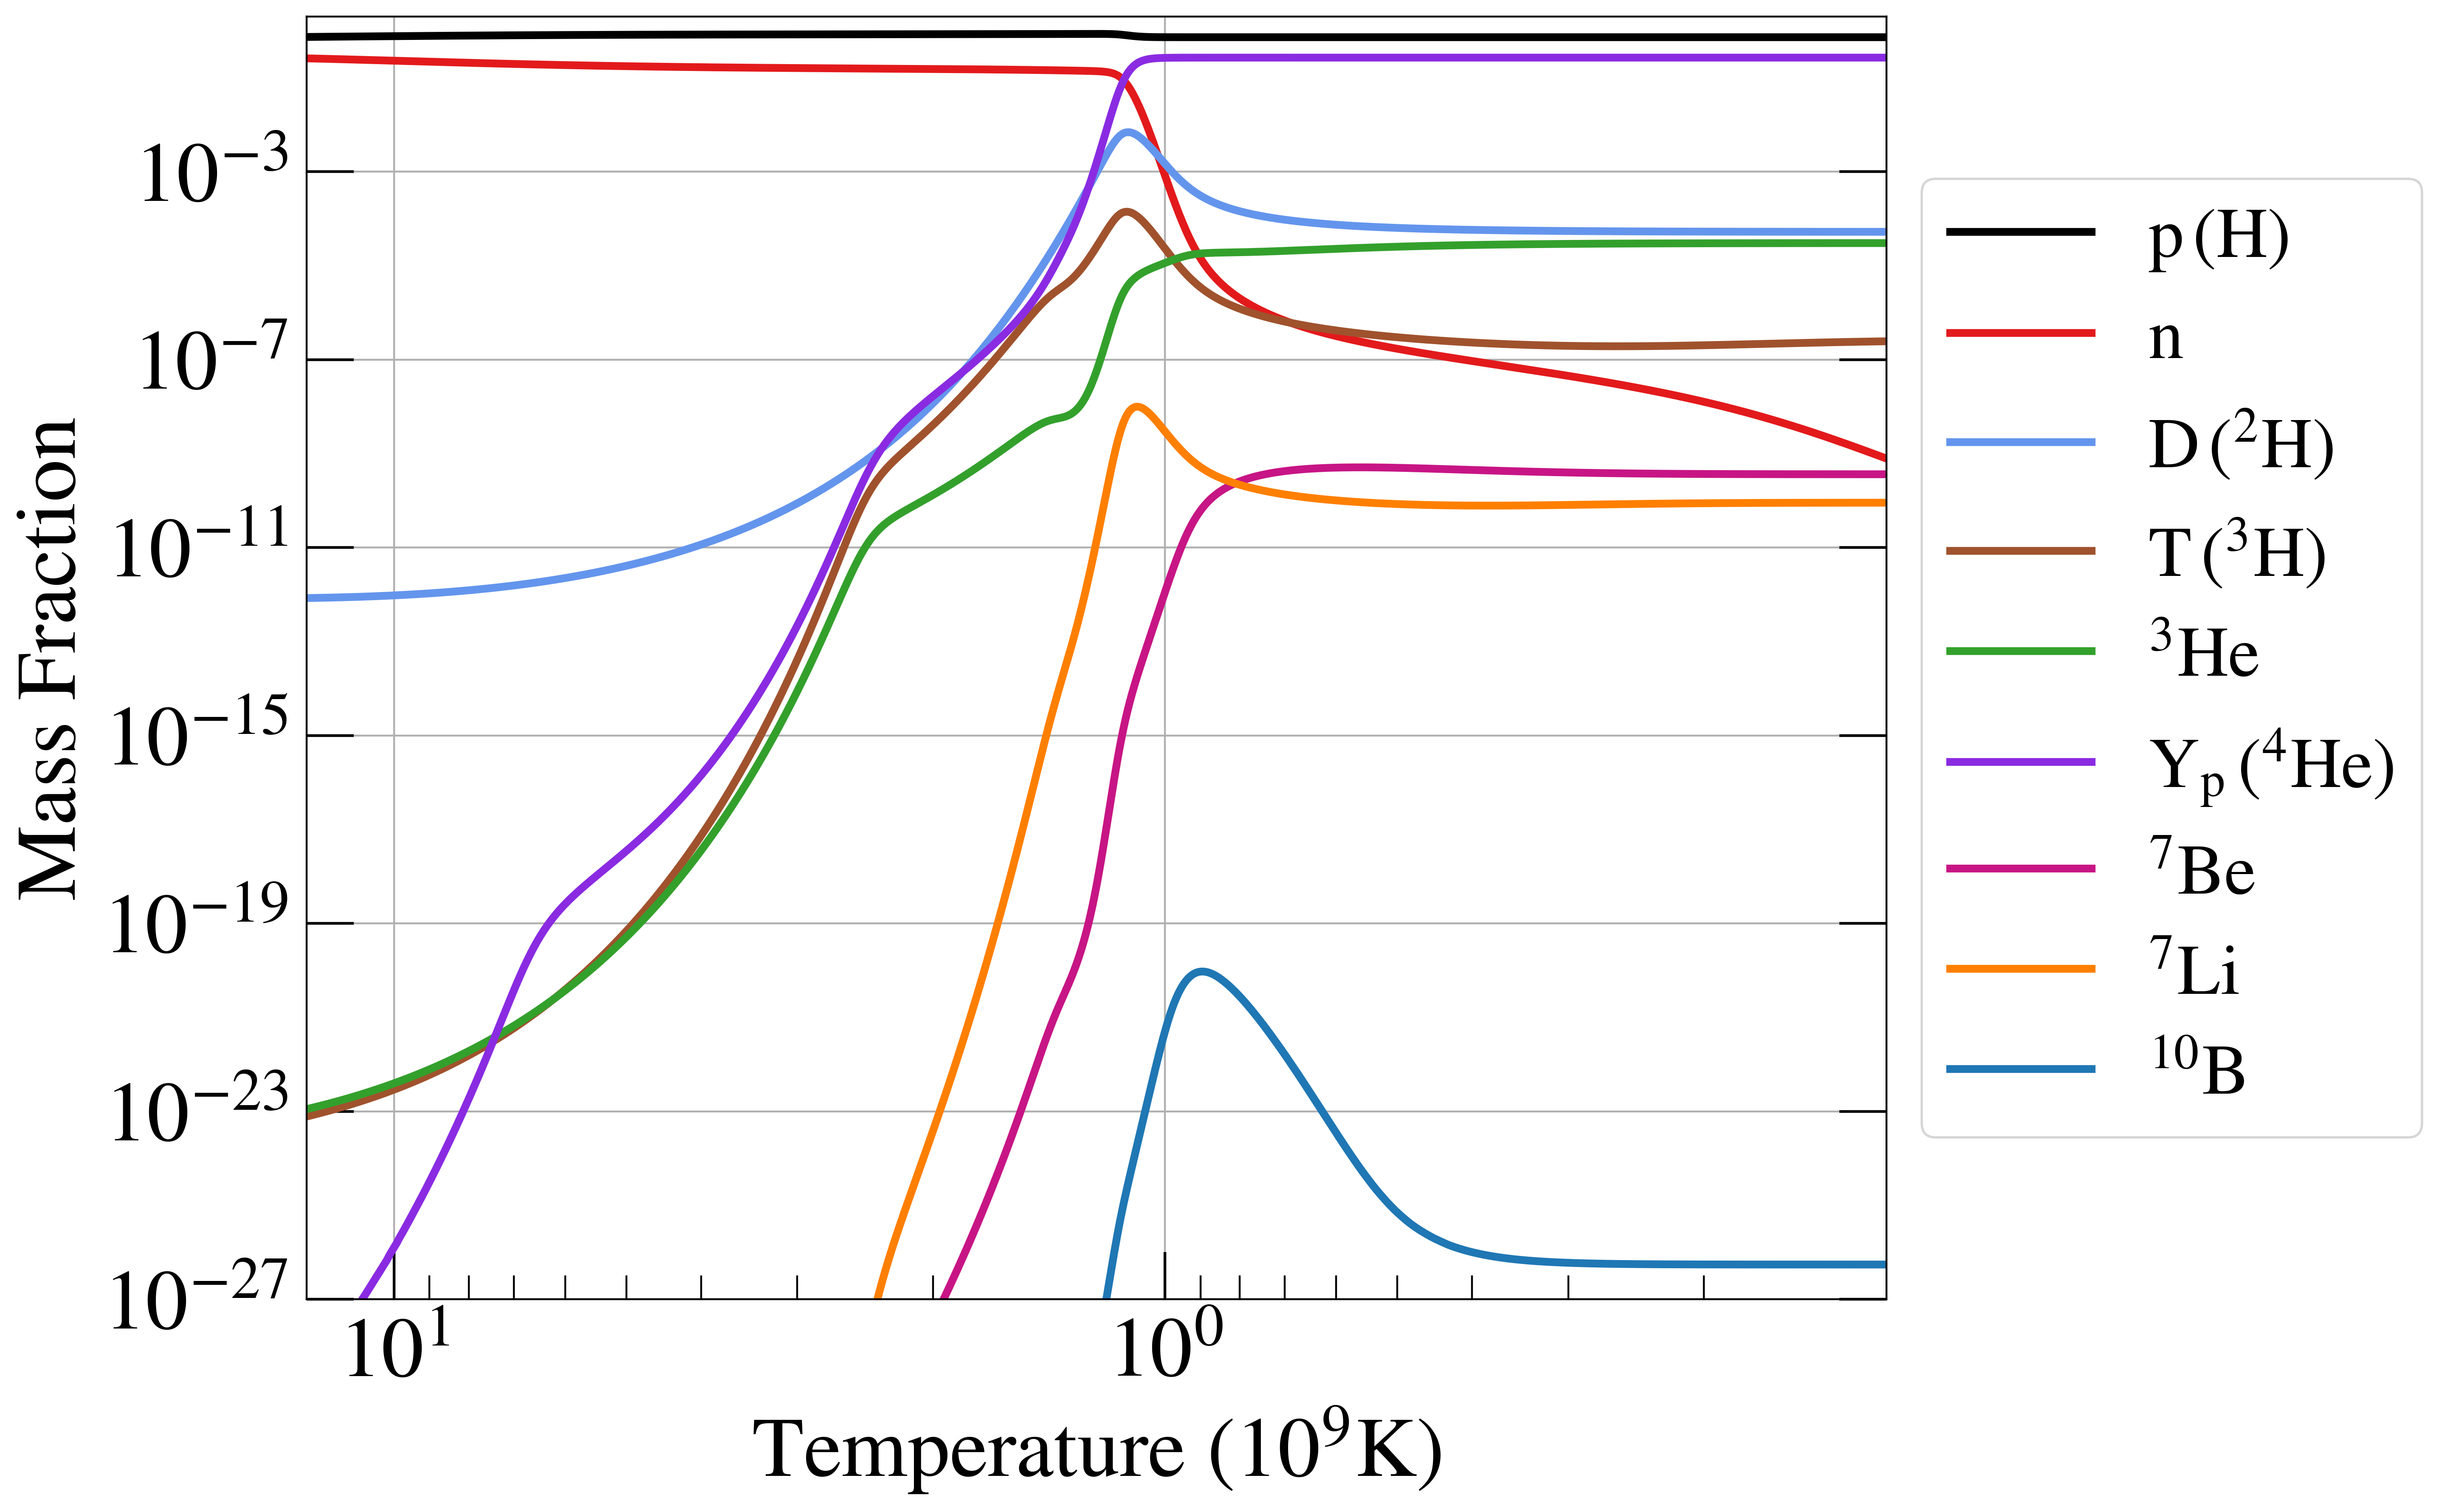

In [21]:
## Initialize the figure and axis
fig = plt.figure(figsize=(15,10), dpi=400)
ax = plt.subplot(111)
ax.grid()

## RC Parameters
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'STIXGeneral'
plt.rcParams['lines.linewidth'] = 3.3
plt.rcParams['font.family'] = 'STIXGeneral'
#colors = ['darkblue', 'red', 'palevioletred', 'coral', 'mediumslateblue', 'darkolivegreen','darkturquoise', 'goldenrod', 'firebrick']
colors = ['black', '#e31a1c', 'cornflowerblue', 'sienna', '#33a02c', 'blueviolet', 'mediumvioletred', '#ff7f00', '#cab2d6']
## Plot
for n in range(8):
    ax.loglog(Tγ, weights[n]*(Y.y[n]), c=colors[n])

ax.loglog(Tγ, weights[9]*Y.y[9])
#ax.loglog(Tγ,rho, linestyle='dotted', color='k')
## Legend
labels = [r'$\rm p \, (H)$', 'n', r'$\rm D \, (^2 H)$', r'$\rm T \, (^3 H)$', r'$\rm ^3He$', r'$\rm Y_p \, (^4 He)$', r'$\rm ^7Be$', r'$\rm ^7Li$',r'$\rm ^{10}B$', r'$\rm \rho_b$']


box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(labels, loc='center left', bbox_to_anchor=(1,0.5), fontsize=30)

## Tick and Ruling Parameters
from matplotlib.ticker import LogFormatterSciNotation, LogLocator
ax.set_xlim(Ti-2,Tf);
ax.set_ylim(1e-27,2e0)


ax.tick_params(axis='both', direction='in', which='major', length = 20, width=1.15, right=True, labelsize=36, pad=8)
ax.tick_params(axis='x', direction='in', length=10, width=0.8, right=True, which='minor')
ax.tick_params(axis='y', direction='in', length=20, width=0.6, right=True,  which='minor', labelsize=15)

ax.xaxis.set_minor_locator(LogLocator())
ax.yaxis.set_minor_locator(LogLocator())
ax.xaxis.set_minor_formatter(LogFormatterSciNotation())
ax.yaxis.set_minor_formatter(LogFormatterSciNotation())
ax.minorticks_on()

## Labels

#ax.set_title('Mass Fraction of Elements in BBN')
ax.set_ylabel('Mass Fraction', fontsize=36)
ax.set_xlabel(r'Temperature ($\rm{10^9 K}$)', fontsize=36)

plt.savefig("BBNTestContrast7.pdf", format="pdf")


In [12]:
# to create a second axis on top with time t:
# functions going both ways based on arrays of t and T
def t_from_T(x):
    # fix for fact that T is decreasing! 
    return np.interp(x, T[::-1], t[::-1], left=0, right=0) 
def T_from_t(x):
    # left and right are key to removing unwanted characters
    return np.interp(x, t, T, left=0, right=0)
# then, later in the code, you will want ( I didn't use the commented lines)
secondaxis = plt.gca().secondary_xaxis('top', functions=(t_from_T, T_from_t))
secondaxis.set_xlabel('$t$ (seconds)', labelpad=10)
#secondaxis.set_xticklabels(['10**(-6)'])
#secondaxis.set_xticks(np.logspace(-9, 3, 13))

Text(0.5, 0, '$t$ (seconds)')

NameError: name 'T' is not defined

<Figure size 432x288 with 1 Axes>